In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm
import math  # Needed for functions like log, exp, etc.
from graphviz import Digraph
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

In [3]:
# ---------------------
# PARAMÈTRES GLOBAUX
# ---------------------
lambda_a = 1.0
lambda_b = 1.0
ka = 0.3
kb = 0.8
eta_a = 0.1
eta_b = 0.1
mu_ab = 0.2

# --------------------
# ---------------------
# DYNAMIQUE DES NEURONES
# ---------------------

def neuron_dynamics_hidden(t, y, x_vec, y_vec, w_p_vec, w_n_vec):
    a, b = y
    da_dt = np.dot(w_p_vec, x_vec) + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = np.dot(w_n_vec, y_vec) + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

def neuron_dynamics_output(t, y, x_in, w_p, theta, N):
    a, b = y
    da_dt = w_p * x_in + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = N + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

# ---------------------
# SIMULATIONS DE COUCHES
# ---------------------

def simulate_hidden_layer(X_vec, Y_vec, neuron_weights):
    X_total = np.sum(X_vec)
    Y_total = np.sum(Y_vec)
    lambda_total = (X_total + Y_total) / len(neuron_weights)
    r = X_total / (X_total + Y_total) if (X_total + Y_total) > 0 else 0.0
    p_vec = X_vec / X_total if X_total > 0 else np.zeros_like(X_vec)
    q_vec = Y_vec / Y_total if Y_total > 0 else np.zeros_like(Y_vec)

    a_vec = []

    for i, (w_p_vec, w_n_vec) in enumerate(neuron_weights):

        n = np.random.poisson(lambda_total)
        m = np.random.binomial(n, r) if n > 0 else 0
        x_vec = np.random.multinomial(m, p_vec) if m > 0 else np.zeros_like(X_vec)
        y_vec = np.random.multinomial(n - m, q_vec) if (n - m) > 0 else np.zeros_like(Y_vec)
        x_in = np.sum(x_vec)
        y_in = np.sum(y_vec)

        sol = solve_ivp(neuron_dynamics_hidden, [0, 2000], [0.0, 0.0],
                args=(x_vec, y_vec, w_p_vec, w_n_vec),
                method='LSODA')

        a_vec.append(sol.y[0, -1])

    return np.array(a_vec)

def simulate_output_layer(a_vec, output_weights, theta_out, N_out):
    x_in = np.dot(output_weights, a_vec)
    sol = solve_ivp(neuron_dynamics_output, [0, 2000], [0.0, 0.0],
                    args=(x_in, 1.0, theta_out, N_out),
                    method='LSODA')
    a, b = sol.y[0, -1], sol.y[1, -1]
    return a / (a + b + 1e-8) if (a + b) > 0 else 0.0

def simulate_network(X_vec, Y_vec, neuron_weights, output_weights, theta_out, N_out):
    a_hidden = simulate_hidden_layer(X_vec, Y_vec, neuron_weights)
    return simulate_output_layer(a_hidden, output_weights, theta_out, N_out)

# ---------------------
# GRILLE & AFFICHAGE
# ---------------------

def run_simulation(n_points, neuron_weights, output_weights, theta_out, N_out):
    x_vals = np.linspace(0, 100, n_points)
    y_vals = np.linspace(0, 100, n_points)
    Y_grid, X_grid = np.meshgrid(y_vals, x_vals)
    Z_grid = np.zeros_like(X_grid)

    total_points = X_grid.size
    iterator = tqdm(range(total_points), desc="Simulation")

    for idx in iterator:
        i = idx // X_grid.shape[1]
        j = idx % X_grid.shape[1]
        x_input = X_grid[i, j]
        y_input = Y_grid[i, j]
        output = simulate_network(
            np.array([x_input]), np.array([y_input]),
            neuron_weights, output_weights,
            theta_out, N_out
        )
        Z_grid[i, j] = output

    return X_grid, Y_grid, Z_grid

def draw_neural_net_from_weights(neuron_weights, output_weights):
    dot = Digraph(format='png')
    dot.attr(rankdir='LR', size='10')

    # Style global des noeuds
    dot.attr('node', shape='circle', style='filled', fontname='Helvetica')

    # Entrées
    dot.node('X1', 'X₁', color='gold', fillcolor='gold')
    dot.node('Y1', 'Y₁', color='deepskyblue', fillcolor='deepskyblue')

    # Couche cachée
    for i, (w_p, w_n) in enumerate(neuron_weights):
        hid_id = f'H{i+1}'
        theta = f'θ{i+1}'
        label = f'{hid_id}(1)\n{theta}'
        dot.node(hid_id, label, color='black', fillcolor='white')

        dot.edge('X1', hid_id, label=f'{w_p:.1f}', color='orange')
        dot.edge('Y1', hid_id, label=f'{w_n:.1f}', color='deepskyblue')

    # Neurone de sortie
    dot.node('OUT', 'OUT\nθ_out + N_out', shape='doublecircle', color='black', fillcolor='white')

    for i, w in enumerate(output_weights):
        hid_id = f'H{i+1}'
        dot.edge(hid_id, 'OUT', label=f'{w:.1f}', color='goldenrod')

    return dot

Simulation: 100%|██████████| 1600/1600 [00:25<00:00, 61.80it/s]


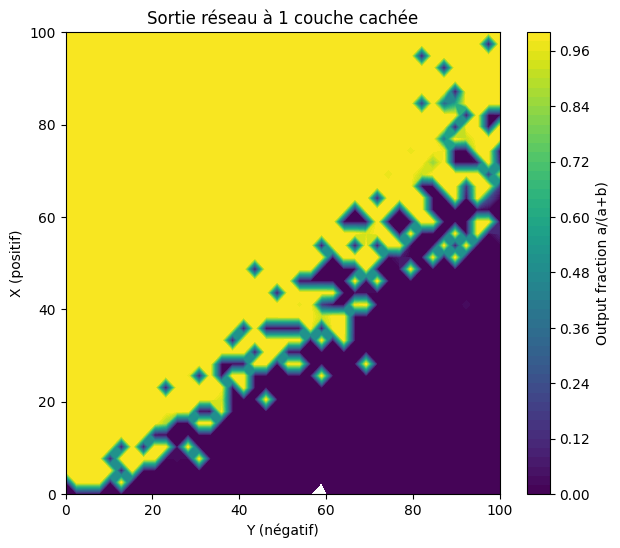

In [ ]:
# ---------------------
# MAIN
# ---------------------

if __name__ == "__main__":
    n_points = 40
    neuron_weights = [
        (1.0, 1.0),
        (0.8, 0.8),
        (1.2, 1.2),
    ]
    output_weights = [1.0, 1.0, 1.0]
    theta_out = 1.0
    N_out = 12.0

    
    graph = draw_neural_net_from_weights(neuron_weights, output_weights)
    graph.render('/mnt/data/dynamic_chemical_net', cleanup=True)
    graph.view('/mnt/data/dynamic_chemical_net')

    X_grid, Y_grid, Z_grid = run_simulation(
        n_points,
        neuron_weights,
        output_weights,
        theta_out,
        N_out
    )

    # AFFICHAGE
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.contourf(Y_grid, X_grid, Z_grid, levels=50, cmap='viridis', vmin=0, vmax=1)
    cbar = fig.colorbar(im, ax=ax, label="Output fraction a/(a+b)")
    ax.set_xlabel("Y (négatif)")
    ax.set_ylabel("X (positif)")
    ax.set_title("Sortie réseau à 1 couche cachée")

    plt.show()


marche pas


c'est le code qui est censé marche pour multilayer

Simulation: 100%|██████████| 625/625 [00:08<00:00, 75.37it/s]


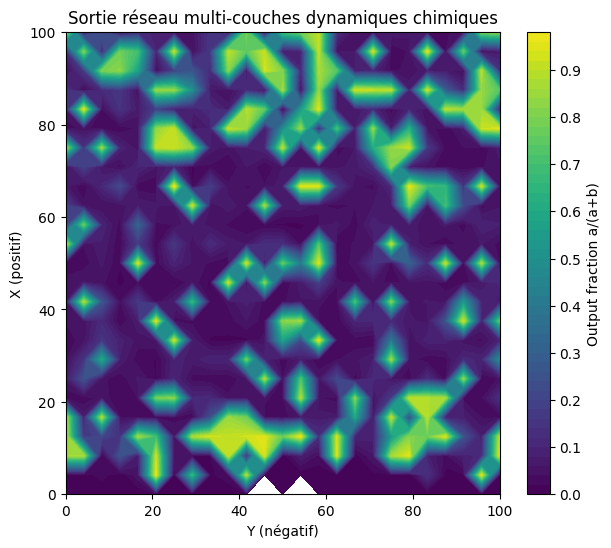

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from graphviz import Digraph
from tqdm import tqdm

# ---------------------
# PARAMÈTRES GLOBAUX
# ---------------------
lambda_a = 1.0
lambda_b = 1.0
ka = 0.3
kb = 0.8
eta_a = 0.1
eta_b = 0.1
mu_ab = 0.2

# ---------------------
# DYNAMIQUE DES NEURONES
# ---------------------

def neuron_dynamics_hidden(t, y, x_vec, w_p_vec, w_n_vec, N=None):
    a, b = y
    da_dt = np.dot(w_p_vec, x_vec) + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_input = np.dot(w_n_vec, x_vec)
    if N is not None:
        db_input += N
    db_dt = db_input + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

def neuron_dynamics_output(t, y, x_in, w_p, theta, N):
    a, b = y
    da_dt = w_p * x_in + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = N + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

# ---------------------
# SIMULATIONS MULTICOUCHE
# ---------------------

def simulate_layer(input_vec, layer_weights, N=None):
    total_input = np.sum(input_vec)
    lambda_total = total_input / len(layer_weights) if len(layer_weights) > 0 else 0.0
    p_vec = input_vec / total_input if total_input > 0 else np.zeros_like(input_vec)

    a_vec = []

    for w_p_vec, w_n_vec in layer_weights:
        n = np.random.poisson(lambda_total)
        x_vec = np.random.multinomial(n, p_vec) if n > 0 else np.zeros_like(input_vec)

        sol = solve_ivp(
            neuron_dynamics_hidden, [0, 2000], [0.0, 0.0],
            args=(x_vec, w_p_vec, w_n_vec, N),
            method='LSODA'
        )
        a_vec.append(sol.y[0, -1])  # species a
    return np.array(a_vec)

def simulate_output_layer(a_vec, output_weights, theta_out, N_out):
    x_in = np.dot(output_weights, a_vec)
    sol = solve_ivp(
        neuron_dynamics_output, [0, 1000], [0.0, 0.0],
        args=(x_in, 1.0, theta_out, N_out),
        method='LSODA'
    )
    a, b = sol.y[0, -1], sol.y[1, -1]
    return a / (a + b) if (a + b) > 0 else 0.0

def simulate_network(X_vec, Y_vec, hidden_layers, output_weights, theta_out, N_out):
    # Couche 1 : prend X et Y
    total_input = np.concatenate((X_vec, Y_vec))
    X_total = np.sum(X_vec)
    Y_total = np.sum(Y_vec)
    lambda_total = (X_total + Y_total) / len(hidden_layers[0]["weights"])
    r = X_total / (X_total + Y_total) if (X_total + Y_total) > 0 else 0.0
    p_vec = X_vec / X_total if X_total > 0 else np.zeros_like(X_vec)
    q_vec = Y_vec / Y_total if Y_total > 0 else np.zeros_like(Y_vec)

    a_vec = []
    for w_p_vec, w_n_vec in hidden_layers[0]["weights"]:
        n = np.random.poisson(lambda_total)
        m = np.random.binomial(n, r) if n > 0 else 0
        x_vec = np.random.multinomial(m, p_vec) if m > 0 else np.zeros_like(X_vec)
        y_vec = np.random.multinomial(n - m, q_vec) if (n - m) > 0 else np.zeros_like(Y_vec)
        x_in = np.sum(x_vec)
        y_in = np.sum(y_vec)

        sol = solve_ivp(neuron_dynamics_hidden, [0, 2000], [0.0, 0.0],
                        args=(x_vec, w_p_vec, w_n_vec, None),
                        method='LSODA')
        a_vec.append(sol.y[0, -1])
    current_output = np.array(a_vec)

    # Couches 2 à L
    for layer in hidden_layers[1:]:
        current_output = simulate_layer(current_output, layer["weights"], N=layer["N"])

    # Sortie
    return simulate_output_layer(current_output, output_weights, theta_out, N_out)

# ---------------------
# GRILLE & AFFICHAGE
# ---------------------
def draw_multilayer_neural_net_from_weights(hidden_layers, output_weights):
    dot = Digraph(format='png')
    dot.attr(rankdir='LR', size='10')
    dot.attr('node', shape='circle', style='filled', fontname='Helvetica')

    # Entrées
    dot.node('X1', 'X₁', color='gold', fillcolor='gold')
    dot.node('Y1', 'Y₁', color='deepskyblue', fillcolor='deepskyblue')

    previous_layer_ids = ['X1', 'Y1']  # pour connecter la première couche

    for layer_index, layer in enumerate(hidden_layers):
        layer_id = f'L{layer_index+1}'
        current_layer_ids = []
        weights = layer["weights"]

        for neuron_index, (w_p_vec, w_n_vec) in enumerate(weights):
            neuron_name = f'H{neuron_index+1}({layer_index+1})'
            dot.node(neuron_name, neuron_name, color='black', fillcolor='white')
            current_layer_ids.append(neuron_name)

            if layer_index == 0:
                # Connexions depuis les entrées X et Y
                dot.edge('X1', neuron_name, label=f'{w_p_vec[0]:.1f}', color='orange')
                dot.edge('Y1', neuron_name, label=f'{w_n_vec[0]:.1f}', color='deepskyblue')
            else:
                # Connexions depuis la couche précédente
                for prev_index, prev_neuron in enumerate(previous_layer_ids):
                    weight_pos = w_p_vec[prev_index]
                    dot.edge(prev_neuron, neuron_name, label=f'{weight_pos:.1f}', color='orange')

        previous_layer_ids = current_layer_ids

    # Neurone de sortie
    dot.node('OUT', 'OUT\nθ_out + N_out', shape='doublecircle', color='black', fillcolor='white')
    for i, hid_id in enumerate(previous_layer_ids):
        dot.edge(hid_id, 'OUT', label=f'{output_weights[i]:.1f}', color='goldenrod')

    return dot


def run_simulation(n_points, hidden_layers, output_weights, theta_out, N_out):
    x_vals = np.linspace(0, 100, n_points)
    y_vals = np.linspace(0, 100, n_points)
    Y_grid, X_grid = np.meshgrid(y_vals, x_vals)
    Z_grid = np.zeros_like(X_grid)

    total_points = X_grid.size
    iterator = tqdm(range(total_points), desc="Simulation")

    for idx in iterator:
        i = idx // X_grid.shape[1]
        j = idx % X_grid.shape[1]
        x_input = X_grid[i, j]
        y_input = Y_grid[i, j]
        output = simulate_network(
            np.array([x_input]), np.array([y_input]),
            hidden_layers, output_weights,
            theta_out, N_out
        )
        Z_grid[i, j] = output

    return X_grid, Y_grid, Z_grid

# ---------------------
# MAIN
# ---------------------

if __name__ == "__main__":
    n_points = 25

    # Architecture à 3 couches : 2 hidden + 1 output
    hidden_layers = [
        {
            "weights": [
                (np.array([1.0]), np.array([1.0])),
                (np.array([0.8]), np.array([0.8])),
                (np.array([1.2]), np.array([1.2]))
            ],
            "N": None  # Pas de source dans la première couche
        },
        {
            "weights": [
                (np.array([1.0, 1.0, 1.0]), np.array([1.0, 1.0, 1.0])),
                (np.array([0.9, 1.0, 1.1]), np.array([0.9, 1.0, 1.1])),
            ],
            "N": 10.0 # Source fixée pour couche 2
        }
    ]

    output_weights = [1.0, 1.0]
    theta_out = 0.0
    N_out = 5.0

    graph = draw_multilayer_neural_net_from_weights(hidden_layers, output_weights)
    graph.render('/mnt/data/dynamic_multilayer_net', cleanup=True)
    graph.view('/mnt/data/dynamic_multilayer_net')


    X_grid, Y_grid, Z_grid = run_simulation(
        n_points,
        hidden_layers,
        output_weights,
        theta_out,
        N_out
    )

    # AFFICHAGE
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.contourf(Y_grid, X_grid, Z_grid, levels=50, cmap='viridis', vmin=0, vmax=1)
    cbar = fig.colorbar(im, ax=ax, label="Output fraction a/(a+b)")
    ax.set_xlabel("Y (négatif)")
    ax.set_ylabel("X (positif)")
    ax.set_title("Sortie réseau multi-couches dynamiques chimiques")

    plt.show()



  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


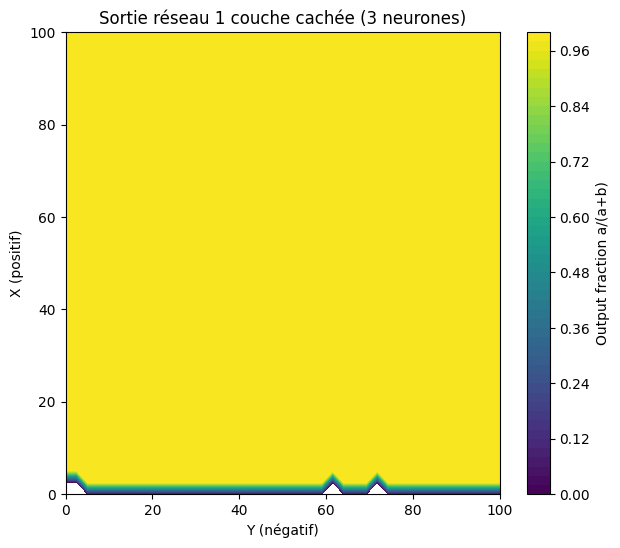

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

# Paramètres globaux (identiques à ton code)
lambda_a = 1.0
lambda_b = 1.0
ka = 0.3
kb = 0.8
eta_a = 0.1
eta_b = 0.1
mu_ab = 0.2

def neuron_dynamics_hidden(t, y, x_vec, w_p_vec, w_n_vec, N=None):
    a, b = y
    da_dt = np.dot(w_p_vec, x_vec) + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_input = np.dot(w_n_vec, x_vec)
    if N is not None:
        db_input += N
    db_dt = db_input + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

def neuron_dynamics_output(t, y, x_in, w_p, theta, N):
    a, b = y
    da_dt = w_p * x_in + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = N + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

def simulate_network(X_vec, Y_vec, hidden_layers, output_weights, theta_out, N_out):
    # Couche 1 (seule couche cachée)
    X_total = np.sum(X_vec)
    Y_total = np.sum(Y_vec)
    lambda_total = (X_total + Y_total) / len(hidden_layers[0]["weights"])
    r = X_total / (X_total + Y_total) if (X_total + Y_total) > 0 else 0.0
    p_vec = X_vec / X_total if X_total > 0 else np.zeros_like(X_vec)
    q_vec = Y_vec / Y_total if Y_total > 0 else np.zeros_like(Y_vec)

    a_vec = []
    for w_p_vec, w_n_vec in hidden_layers[0]["weights"]:
        n = np.random.poisson(lambda_total)
        m = np.random.binomial(n, r) if n > 0 else 0
        x_vec = np.random.multinomial(m, p_vec) if m > 0 else np.zeros_like(X_vec)
        y_vec = np.random.multinomial(n - m, q_vec) if (n - m) > 0 else np.zeros_like(Y_vec)
        sol = solve_ivp(neuron_dynamics_hidden, [0, 2000], [0.0, 0.0],
                        args=(x_vec, w_p_vec, w_n_vec, None),
                        method='LSODA')
        a_vec.append(sol.y[0, -1])
    a_vec = np.array(a_vec)

    # Sortie
    x_in = np.dot(output_weights, a_vec)
    sol = solve_ivp(neuron_dynamics_output, [0, 1000], [0.0, 0.0],
                    args=(x_in, 1.0, theta_out, N_out),
                    method='LSODA')
    a, b = sol.y[0, -1], sol.y[1, -1]
    return a / (a + b) if (a + b) > 0 else 0.0

# Paramètres de test
n_points = 40
hidden_layers = [
    {
        "weights": [
            (np.array([1.0]), np.array([1.0])),
            (np.array([0.8]), np.array([0.8])),
            (np.array([1.2]), np.array([1.2]))
        ],
        "N": None
    }
]
output_weights = [1.0, 1.0, 1.0]
theta_out = 1.0
N_out = 12.0

# Simulation sur la grille
x_vals = np.linspace(0, 100, n_points)
y_vals = np.linspace(0, 100, n_points)
Y_grid, X_grid = np.meshgrid(y_vals, x_vals)
Z_grid = np.zeros_like(X_grid)

for i in tqdm(range(X_grid.shape[0])):
    for j in range(X_grid.shape[1]):
        x_in = X_grid[i, j]
        y_in = Y_grid[i, j]
        Z_grid[i, j] = simulate_network(
            np.array([x_in]), np.array([y_in]),
            hidden_layers, output_weights, theta_out, N_out
        )

# Affichage
plt.figure(figsize=(7, 6))
plt.contourf(Y_grid, X_grid, Z_grid, levels=50, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label="Output fraction a/(a+b)")
plt.xlabel("Y (négatif)")
plt.ylabel("X (positif)")
plt.title("Sortie réseau 1 couche cachée (3 neurones)")
plt.show()


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


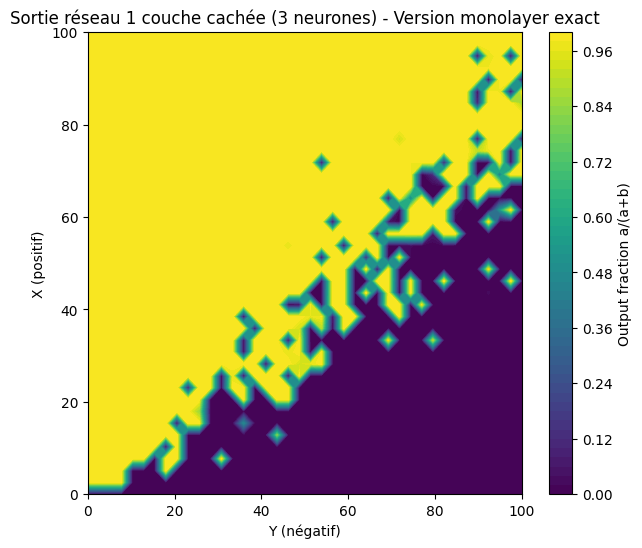

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

# Paramètres globaux (identiques)
lambda_a = 1.0
lambda_b = 1.0
ka = 0.3
kb = 0.8
eta_a = 0.1
eta_b = 0.1
mu_ab = 0.2

# Fonction dynamique cachée exactement comme dans le code monolayer
def neuron_dynamics_hidden(t, y, x_vec, y_vec, w_p_vec, w_n_vec):
    a, b = y
    da_dt = np.dot(w_p_vec, x_vec) + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = np.dot(w_n_vec, y_vec) + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

def neuron_dynamics_output(t, y, x_in, w_p, theta, N):
    a, b = y
    da_dt = w_p * x_in + (lambda_a * a) / (1 + ka * a) - eta_a * a - mu_ab * a * b
    db_dt = N + (lambda_b * b) / (1 + kb * b) - eta_b * b - mu_ab * a * b
    return [da_dt, db_dt]

def simulate_network(X_vec, Y_vec, hidden_layers, output_weights, theta_out, N_out):
    # Ici, on prend la couche 1 (la seule couche cachée)
    weights = hidden_layers[0]["weights"]
    a_vec = []

    # Calcul des totaux et proportions
    X_total = np.sum(X_vec)
    Y_total = np.sum(Y_vec)
    lambda_total = (X_total + Y_total) / len(weights)
    r = X_total / (X_total + Y_total) if (X_total + Y_total) > 0 else 0.0
    p_vec = X_vec / X_total if X_total > 0 else np.zeros_like(X_vec)
    q_vec = Y_vec / Y_total if Y_total > 0 else np.zeros_like(Y_vec)

    # Simulation pour chaque neurone caché
    for w_p_vec, w_n_vec in weights:
        n = np.random.poisson(lambda_total)
        m = np.random.binomial(n, r) if n > 0 else 0
        x_vec = np.random.multinomial(m, p_vec) if m > 0 else np.zeros_like(X_vec)
        y_vec = np.random.multinomial(n - m, q_vec) if (n - m) > 0 else np.zeros_like(Y_vec)

        sol = solve_ivp(neuron_dynamics_hidden, [0, 2000], [0.0, 0.0],
                        args=(x_vec, y_vec, w_p_vec, w_n_vec),
                        method='LSODA')

        a_vec.append(sol.y[0, -1])

    a_vec = np.array(a_vec)

    # Couche de sortie
    x_in = np.dot(output_weights, a_vec)
    sol = solve_ivp(neuron_dynamics_output, [0, 1000], [0.0, 0.0],
                    args=(x_in, 1.0, theta_out, N_out),
                    method='LSODA')
    a, b = sol.y[0, -1], sol.y[1, -1]
    return a / (a + b) if (a + b) > 0 else 0.0

# Paramètres de test
n_points = 40
hidden_layers = [
    {
        "weights": [
            (np.array([1.0]), np.array([1.0])),
            (np.array([0.8]), np.array([0.8])),
            (np.array([1.2]), np.array([1.2]))
        ],
        "N": None
    }
]
output_weights = [1.0, 1.0, 1.0]
theta_out = 1.0
N_out = 12.0

# Simulation sur la grille
x_vals = np.linspace(0, 100, n_points)
y_vals = np.linspace(0, 100, n_points)
Y_grid, X_grid = np.meshgrid(y_vals, x_vals)
Z_grid = np.zeros_like(X_grid)

for i in tqdm(range(X_grid.shape[0])):
    for j in range(X_grid.shape[1]):
        x_in = X_grid[i, j]
        y_in = Y_grid[i, j]
        Z_grid[i, j] = simulate_network(
            np.array([x_in]), np.array([y_in]),
            hidden_layers, output_weights, theta_out, N_out
        )

import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
plt.contourf(Y_grid, X_grid, Z_grid, levels=50, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label="Output fraction a/(a+b)")
plt.xlabel("Y (négatif)")
plt.ylabel("X (positif)")
plt.title("Sortie réseau 1 couche cachée (3 neurones) - Version monolayer exact")
plt.show()
